In [1]:
import gym

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from collections import namedtuple
import random
import matplotlib.pyplot as plt
import copy

In [98]:
ENV_NAME = 'Pendulum-v0'
env = gym.make(ENV_NAME)
TAU = .01
GAMMA = .9
LR_actor = .01
LR_critic = .01
EXPERIENCE_CAPACITY = 4000
TARGET_UPDATE_FREQUENCY = 200
MAX_EPI = 10
MAX_STEP = 400
BATCH_SIZE = 32
#EPSILON = .1
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.shape[0]

[2017-08-09 11:29:23,319] Making new env: Pendulum-v0


In [99]:
# initialization
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

In [100]:
# classes
class Experience(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.mem = []
        self.pos = 0
    
    def push(self, o, a, r, o_next):
        if len(self.mem) < self.capacity:
            self.mem.append(None)
        self.mem[self.pos] = Transition(o, a, r, o_next)
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, size):
        return random.sample(self.mem, min(size, len(self.mem)))
        #return self.mem[:min(size, len(self.mem))]
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fcS = nn.Linear(N_STATES, 3)
        #self.fcS.weight.data = torch.ones(self.fcS.weight.data.size())
        #self.fcS.bias.data = torch.ones(self.fcS.bias.data.size())
        self.fcS.weight.data.normal_(0, 0.1)
        self.fcA = nn.Linear(N_ACTIONS, 3)
        #self.fcA.weight.data = torch.ones(self.fcA.weight.data.size())
        #self.fcA.bias.data = torch.ones(self.fcA.bias.data.size())
        self.fcA.weight.data.normal_(0, 0.1)
        self.fcO = nn.Linear(6, 1)
        #self.fcO.weight.data = torch.ones(self.fcO.weight.data.size())
        #self.fcO.bias.data = torch.ones(self.fcO.bias.data.size())
        self.fcO.weight.data.normal_(0, 0.1)
    
    def forward(self, x, y):
        s = self.fcS(x)
        s = F.relu(s)
        a = self.fcA(y)
        a = F.relu(a)
        o = self.fcO(torch.cat([s,a], 1))
        return o

class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 30)
        #self.fc1.weight.data = torch.ones(self.fc1.weight.data.size())
        #self.fc1.bias.data = torch.ones(self.fc1.bias.data.size())
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(30, N_ACTIONS)
        #self.fc2.weight.data = torch.ones(self.fc2.weight.data.size())
        #self.fc2.bias.data = torch.ones(self.fc2.bias.data.size())
        self.fc2.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [101]:
#action_list = np.arange(-2.0, 2.1, .4)
#def choose_action(state, critic):
#    s = Variable(Tensor(state)).unsqueeze(0)
#    v = []
#    for action in action_list:
#        a = Variable(Tensor(np.array([action]))).unsqueeze(0)
#        v.append(critic(s, a).data.cpu().numpy()[0][0].astype('float64'))
#    v = Tensor(np.array(v))
#    idx = v.max(0)[1].cpu().numpy()[0]
#    print v, '\n', idx
#    return np.array([action_list[idx]])

def choose_action(state, actor):
    a = actor(Variable(Tensor(state).unsqueeze(0))).data.cpu().numpy()[0].astype('float64')
    return a

def update_actor_critic(target_actor, target_critic, \
                       actor, critic, exp, optim_actor, optim_critic):
    # sample minibatch
    minibatch = Transition(*zip(*exp.sample(BATCH_SIZE)))
    bat_o = Variable(Tensor(minibatch.state))
    bat_a = Variable(Tensor(minibatch.action))
    bat_r = Variable(Tensor(minibatch.reward)).unsqueeze(1)
    bat_o_ = Variable(Tensor(minibatch.next_state))
    
    # update critic
    #bat_a_ = [choose_action(o_, target_critic) for o_ in minibatch.next_state]
    #bat_a_ = Variable(Tensor(bat_a_))
    #Gt = bat_r + GAMMA * target_critic(bat_o_, bat_a_)
    
    Gt = bat_r + GAMMA * target_critic(bat_o_, target_actor(bat_o_))
    Gt.detach_()
    eval_o = critic(bat_o, bat_a)
    criterion = nn.MSELoss()
    if use_cuda:
        criterion.cuda()
    loss = criterion(eval_o, Gt)
    #optimizer = optim.Adam(critic.parameters(), lr=LR_critic)
    optim_critic.zero_grad()
    loss.backward()
    optim_critic.step()
    
    # update actor
    obj = torch.mean(critic(bat_o, actor(bat_o)))
    #optimizer = optim.Adam(actor.parameters(), lr=-LR_actor)
    optim_actor.zero_grad()
    obj.backward()
    optim_actor.step()

def update_target(target_actor, target_critic, \
                         actor, critic):
    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())

def soft_update(target, behavior, tau):
    #for target_param, behavior_param in zip(target.parameters(), behavior.parameters()):
    #    target_param.data.copy_(
    #        tau * behavior_param.data + (1-tau) * target_param.data
    #    )
    
    for key in target.state_dict().keys():
        target.state_dict()[key].copy_(tau * behavior.state_dict()[key] + (1-tau) * target.state_dict()[key])
    #    target.state_dict()[key] = tau * behavior.state_dict()[key] + (1-tau) * target.state_dict()[key]
        
def replace(target_net, net):
    target_net.load_state_dict(net.state_dict())

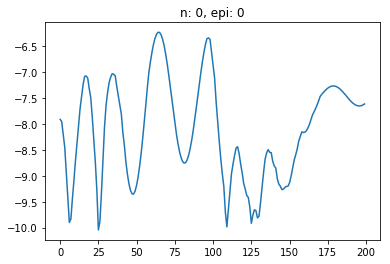

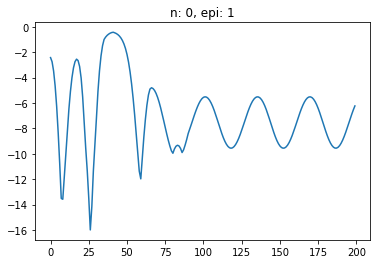

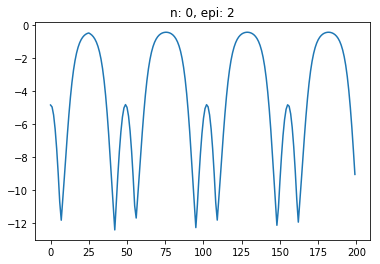

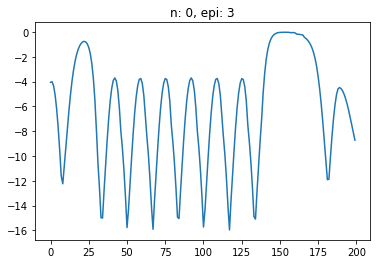

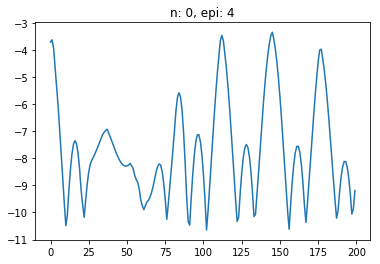

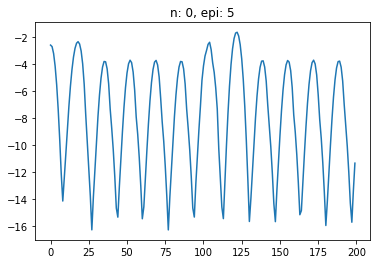

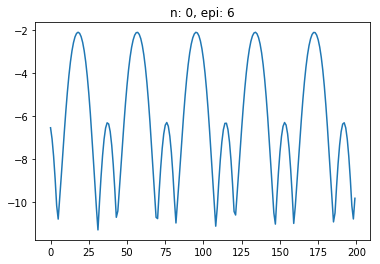

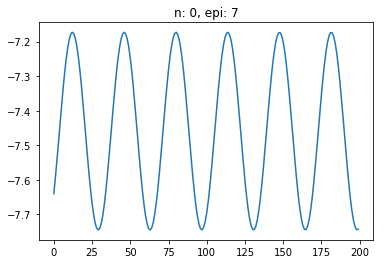

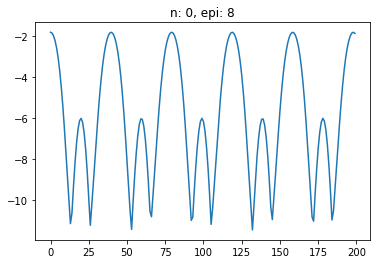

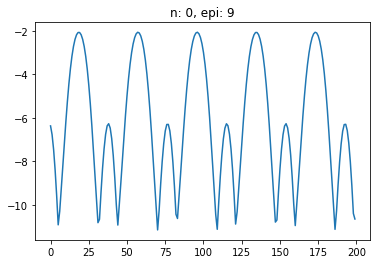

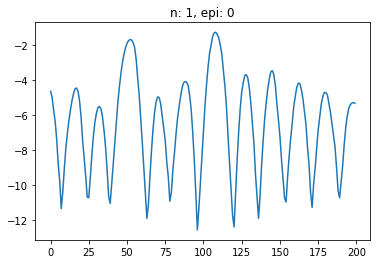

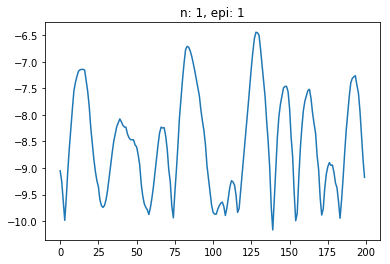

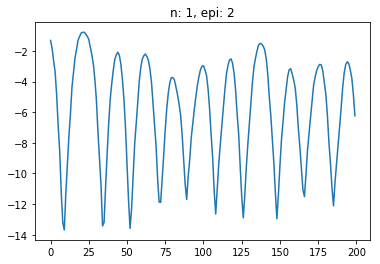

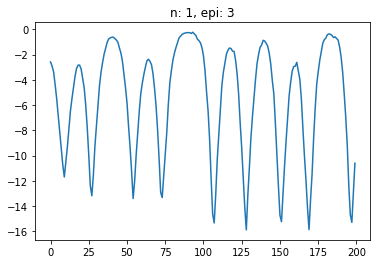

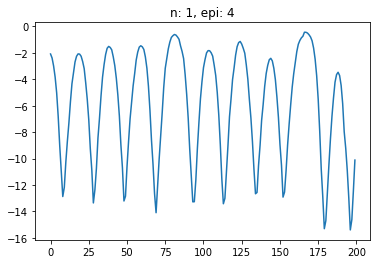

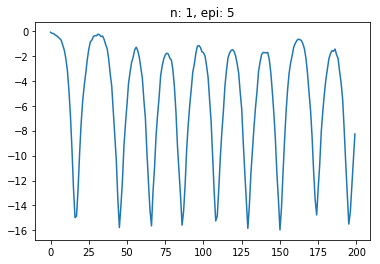

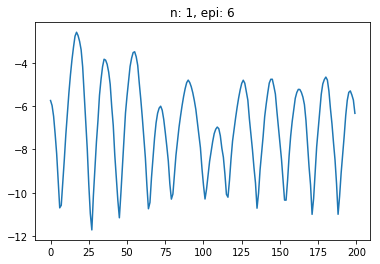

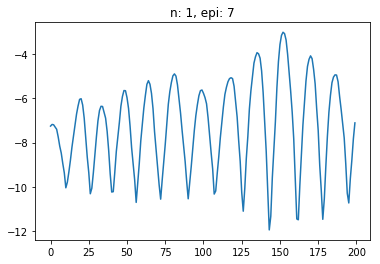

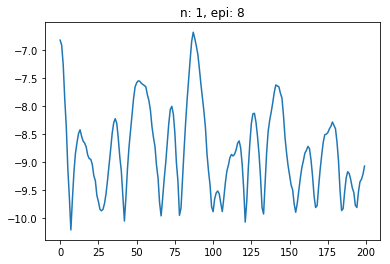

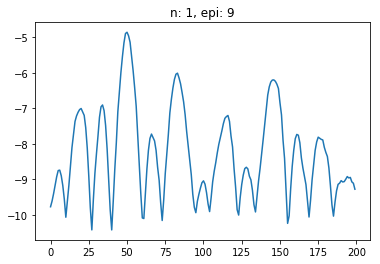

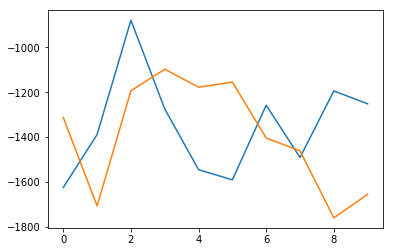

In [102]:
n_vec_r = []
for n in xrange(2):    
    target_actor = Actor()
    target_critic = Critic()
    actor = Actor()
    critic = Critic()
    if use_cuda:
        target_actor.cuda()
        target_critic.cuda()
        actor.cuda()
        critic.cuda()
    exp = Experience(EXPERIENCE_CAPACITY)
    optim_critic = optim.Adam(critic.parameters(), lr=LR_critic)
    optim_actor = optim.Adam(actor.parameters(), lr=-LR_actor)

    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())
    
    vec_r = []
    update_counter = 0
    for epi in xrange(MAX_EPI):
        o = env.reset()
        acc_r = 0
        
        local_r = []
        
        for t in xrange(MAX_STEP):    
            #a = choose_action(o, critic)
            a = choose_action(o, actor)
            a = np.random.normal(a, 3)
            a = np.clip(a, -2, 2)
            
            o_, r, done, info = env.step(a)
            exp.push(o, a, r, o_)
            
            dict_critic = copy.deepcopy(critic.state_dict())
            
            update_actor_critic(target_actor, target_critic, \
                               actor, critic, exp, optim_actor, optim_critic)
            update_counter += 1
            
            dict_critic_diff = {}
            for key in dict_critic:
                dict_critic_diff[key] = torch.sum(critic.state_dict()[key] - dict_critic[key])
            #print dict_critic_diff
            
            soft_update(target_critic, critic, TAU)
            soft_update(target_actor, actor, TAU)
            #if update_counter % TARGET_UPDATE_FREQUENCY == 0:
            #    update_target(target_actor, target_critic, \
            #                 actor, critic)
            #if update_counter % 300 == 0:
            #    replace(target_critic, critic)
            #if update_counter % 500 == 0:
            #    replace(target_actor, actor)
            
            local_r.append(r)
            acc_r += r
            o = o_
            if done:
                break

        if epi % (MAX_EPI/10) == (MAX_EPI/10)-1:
            plt.plot(xrange(len(local_r)), local_r)
            plt.title('n: {}, epi: {}'.format(n, epi))
            plt.show()

        vec_r.append(acc_r)
    n_vec_r.append(vec_r)

for i, vec in enumerate(n_vec_r):
    plt.plot(xrange(len(vec)), vec, label='{}'.format(i))
plt.show()

In [97]:
for i, vec in enumerate(n_vec_r):
    plt.plot(xrange(len(vec)), vec, label='{}'.format(i))
plt.show()

1


In [83]:
target = target_critic
behavior = critic
tau = 1
tmp = Tensor(np.ones((3,3)))
print target.state_dict()
print '----------------------------------------'
soft_update(target, behavior, tau)
print target.state_dict()
print '----------------------------------------'
print behavior.state_dict()

OrderedDict([('fcS.weight', 
-1.5538  0.0018  1.5565
-1.7024 -0.2533 -1.4048
 0.2027  0.0079  0.0020
[torch.cuda.FloatTensor of size 3x3 (GPU 0)]
), ('fcS.bias', 
 1.5495
 1.9050
-0.4366
[torch.cuda.FloatTensor of size 3 (GPU 0)]
), ('fcA.weight', 
-0.0629
-0.7112
 0.3998
[torch.cuda.FloatTensor of size 3x1 (GPU 0)]
), ('fcA.bias', 
-0.7036
 1.1923
 1.7607
[torch.cuda.FloatTensor of size 3 (GPU 0)]
), ('fcO.weight', 
-1.5756 -1.6753  0.1147  0.0448 -0.9328 -1.1321
[torch.cuda.FloatTensor of size 1x6 (GPU 0)]
), ('fcO.bias', 
-1.1505
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)])
----------------------------------------
OrderedDict([('fcS.weight', 
-1.9201  0.2211  1.8677
-2.0089 -0.1144 -1.7183
 0.2027  0.0079  0.0020
[torch.cuda.FloatTensor of size 3x3 (GPU 0)]
), ('fcS.bias', 
 1.8967
 2.2051
-0.4366
[torch.cuda.FloatTensor of size 3 (GPU 0)]
), ('fcA.weight', 
-0.0629
-0.8361
 0.3963
[torch.cuda.FloatTensor of size 3x1 (GPU 0)]
), ('fcA.bias', 
-0.7036
 1.5250
 2.1200
[torch.cuda.Fl